In [ ]:
!pip install torch torchvision matplotlib tqdm einops --quiet
!pip install pytorch-fid --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from einops import rearrange

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


In [ ]:
class ScoreNet(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(channels + 1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.out = nn.Conv2d(64, channels, 3, padding=1)

    def forward(self, x, t):
        t_embed = t.view(-1, 1, 1, 1).repeat(1, 1, x.shape[2], x.shape[3])
        x_in = torch.cat([x, t_embed], dim=1)
        h = F.relu(self.conv1(x_in))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        return self.out(h)

In [ ]:
class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T

    def beta(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def marginal_std(self, t):
        return torch.sqrt(1. - torch.exp(-2 * self._integral_beta(t)))

    def _integral_beta(self, t):
        return self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2

    def sde(self, x, t):
        beta_t = self.beta(t)
        drift = -0.5 * beta_t[:, None, None, None] * x
        diffusion = torch.sqrt(beta_t)
        return drift, diffusion

    def reverse_sde(self, x, t, score):
        drift, diffusion = self.sde(x, t)
        return drift - diffusion[:, None, None, None]**2 * score, diffusion

In [ ]:
def loss_fn(model, sde, x0):
    device = x0.device
    t = torch.rand(x0.shape[0], device=device) * sde.T
    z = torch.randn_like(x0)
    std = sde.marginal_std(t).view(-1, 1, 1, 1)
    xt = x0 * torch.exp(-0.5 * sde._integral_beta(t)).view(-1, 1, 1, 1) + std * z
    score_pred = model(xt, t)
    loss = ((score_pred * std + z)**2).mean()
    return loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ScoreNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
sde = VPSDE()

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, _ in tqdm(trainloader, desc=f"Epoch {epoch+1}"):           # switch to a gpu runtime, I beg!
        x = x.to(device)
        loss = loss_fn(model, sde, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(trainloader):.4f}")

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 Loss: 0.1769


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 Loss: 0.0864


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 Loss: 0.0669


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 Loss: 0.0580


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 Loss: 0.0532


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 Loss: 0.0499


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 Loss: 0.0491


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8 Loss: 0.0468


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9 Loss: 0.0465


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10 Loss: 0.0442


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11 Loss: 0.0437


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12 Loss: 0.0426


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13 Loss: 0.0412


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14 Loss: 0.0414


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15 Loss: 0.0410


Epoch 16:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16 Loss: 0.0401


Epoch 17:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17 Loss: 0.0398


Epoch 18:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18 Loss: 0.0401


Epoch 19:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19 Loss: 0.0394


Epoch 20:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20 Loss: 0.0383


In [ ]:
@torch.no_grad()
def sample(model, sde, shape=(64, 3, 32, 32), steps=1000):
    model.eval()
    x = torch.randn(shape).to(device)
    t = torch.linspace(sde.T, 1e-5, steps, device=device)
    dt = -1. / steps

    for i in range(steps):
        ti = t[i].expand(shape[0])
        score = model(x, ti)
        drift, diffusion = sde.reverse_sde(x, ti, score)
        z = torch.randn_like(x) if i < steps - 1 else 0
        x += drift * dt + diffusion[:, None, None, None] * np.sqrt(-dt) * z
    return x


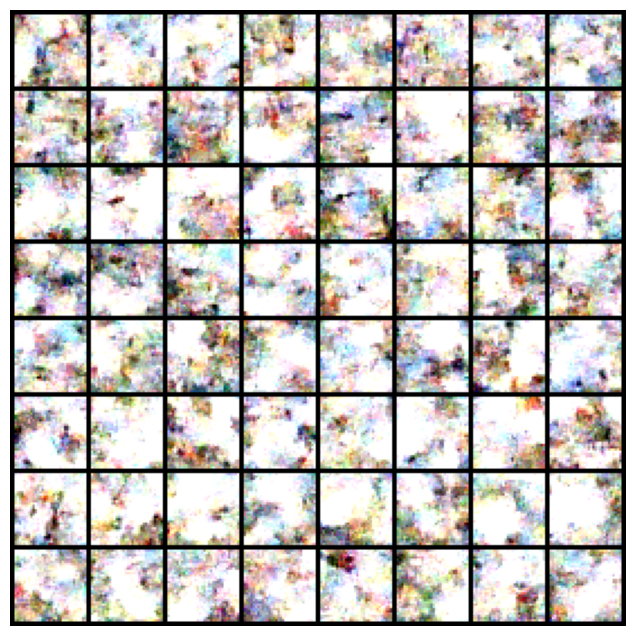

In [ ]:
samples = sample(model, sde)
samples = (samples.clamp(-1, 1) + 1) / 2
grid = torchvision.utils.make_grid(samples, nrow=8)       # man wtf?!... I don't know what I was doing here.
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())